In [1]:
# Restric calcuation of psl accuracy to only those cell lines/Gene pair that has information
# contribution to the final output

### Only active
# predict everything
# predict with data

### Only essential
# predict everything
# predict with data

### both rules
# predict everything
# predict with at least one type of data
# predict with both types of data

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import compare_y

%matplotlib inline


In [7]:
infer_file = "../psl/result/first_model/cross_val_fold{0}_result{1}.txt"
train_file = "../psl/data/first_model/seed0/cross_val/5fold/fold{0}_train.txt"
test_file = "../psl/data/first_model/seed0/cross_val/5fold/fold{0}_val.txt"

In [8]:
# Define some helper functions 
def get_gene_drug_dict():
    drug_target_file = "../psl/data/first_model/drug_target.txt"
    drug_target_df = pd.read_csv(drug_target_file, delimiter="\t", header=None)
    drug_target_dict = {}
    for index, row in drug_target_df.iterrows():
        if row[1] in drug_target_dict.keys():
            drug_target_dict[row[1]].append(row[0])
        else:
            drug_target_dict[row[1]] = [row[0]]
    return drug_target_dict


def get_active_cell_drug_set(gene_drug_dict):
    active_df = pd.read_csv("../psl/data/first_model/active.txt", delimiter="\t", header=None)
    active_cell_drug_pairs = []
    for index, row in active_df.iterrows():
        if row[1] in gene_drug_dict.keys():
            for drug in gene_drug_dict[row[1]]:
                active_cell_drug_pairs.append(row[0] + drug)
    return set(active_cell_drug_pairs)


def get_essential_cell_drug_set(gene_drug_dict):
    essential_df = pd.read_csv("../psl/data/first_model/essential.txt", delimiter="\t", header=None)
    cell_drug_pairs = []
    for index, row in essential_df.iterrows():
        if row[1] in gene_drug_dict.keys():
            for drug in gene_drug_dict[row[1]]:
                cell_drug_pairs.append(row[0] + drug)
    return set(cell_drug_pairs)
    
def get_sensitive_cell_drug_set():
    sensitive_df = pd.read_csv("../psl/data/first_model/sensitive_truth.txt", delimiter="\t", header=None)
    cell_drug_pairs = []
    for index, row in sensitive_df.iterrows():
        cell_drug_pairs.append(row[0] + row[1])
    return set(cell_drug_pairs)

gene_drug_dict = get_gene_drug_dict()
active_set = get_active_cell_drug_set(gene_drug_dict)
essential_set = get_essential_cell_drug_set(gene_drug_dict)

In [9]:
# helper function to get overlap between a set and a df
def get_df_overlap(df, cell_drug_set):
    new_rows = []
    for index, row in df.iterrows():
        if row.cell_drug_pair in cell_drug_set:
            new_rows.append(dict(row))
    return pd.DataFrame(new_rows)

   test_all_data  test_known_active  train_all_data  train_known_active
0       0.083975           0.077732        0.083574            0.077740
1       0.083097           0.078669        0.083789            0.077502
2       0.085832           0.076986        0.083107            0.077923
3       0.082694           0.077849        0.083887            0.077704
4       0.082677           0.077461        0.083902            0.077811


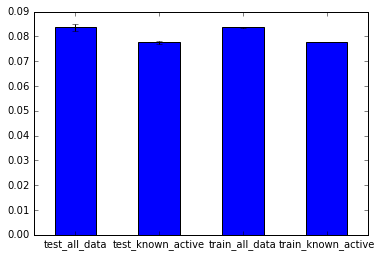

In [12]:
# Only active rule
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, "_activeRule"))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, active_set)
    val_df_has_data = get_df_overlap(val_df, active_set)
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df)
    
    rows.append({"train_all_data": tr_mse, "test_all_data": val_mse, 
                 "train_known_active": tr_mse_has_data, "test_known_active": val_mse_has_data})
df = pd.DataFrame(rows)
df.mean().plot.bar(yerr=df.std(), rot=0)

print df

In [75]:
# Only active rule on essential data
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, "_activeRule"))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, active_set)
    val_df_has_data = get_df_overlap(val_df, active_set)
    
    tr_df_has_essen_data = get_df_overlap(tr_df, essential_set)
    val_df_has_essen_data = get_df_overlap(val_df, essential_set)
    
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df)
    
    tr_mse_has_essen_data, _, _ = compare_y.calculate_accuracy(tr_df_has_essen_data, infer_df)
    val_mse_has_essen_data, _, _ = compare_y.calculate_accuracy(val_df_has_essen_data, infer_df)
    
    rows.append({"train_all_data": tr_mse, "test_all_data": val_mse, 
                 "train_known_active": tr_mse_has_data, "test_known_active": val_mse_has_data,
                 "train_known_essential": tr_mse_has_essen_data, "test_known_essential": val_mse_has_essen_data})
df = pd.DataFrame(rows)
print df

   test_all_data  test_known_active  test_known_essential  train_all_data  \
0       0.083975           0.077732              0.077777        0.083574   
1       0.083097           0.078669              0.072338        0.083789   
2       0.085832           0.076986              0.069407        0.083107   
3       0.082694           0.077849              0.078171        0.083887   
4       0.082677           0.077461              0.075882        0.083902   

   train_known_active  train_known_essential  
0            0.077740               0.074072  
1            0.077502               0.075369  
2            0.077923               0.076095  
3            0.077704               0.073867  
4            0.077811               0.074574  


In [74]:
# Only essential rule
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, "_essentialRule"))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, essential_set)
    val_df_has_data = get_df_overlap(val_df, essential_set)
    
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df)
    
    rows.append({"train_all_data": tr_mse, "test_all_data": val_mse, 
                 "train_known_essential": tr_mse_has_data, "test_known_essential": val_mse_has_data})
df = pd.DataFrame(rows)
print df




   test_all_data  test_known_essential  train_all_data  train_known_essential
0       0.299009              0.142034        0.295346               0.134927
1       0.302881              0.131006        0.294355               0.137521
2       0.293684              0.129386        0.296664               0.137975
3       0.301773              0.136626        0.294628               0.136155
4       0.283043              0.142160        0.299395               0.135150


In [72]:
# both rules
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, ""))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, essential_set.union(active_set))
    val_df_has_data = get_df_overlap(val_df, essential_set.union(active_set))
    
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df) 

    tr_df_both_data = get_df_overlap(tr_df, essential_set.intersection(active_set))
    val_df_both_data = get_df_overlap(val_df, essential_set.intersection(active_set))
    
    
    tr_mse_both_data, _, _ = compare_y.calculate_accuracy(tr_df_both_data, infer_df)
    val_mse_both_data, _, _ = compare_y.calculate_accuracy(val_df_both_data, infer_df)

    
    rows.append({"train_all": tr_mse, "test_all": val_mse, 
                 "train_has_>=1_type_of_data": tr_mse_has_data, "test_has_>=1_type_of_data": val_mse_has_data, 
                 "train_both_data": tr_mse_both_data, "test_both_data": val_mse_both_data})

    df = pd.DataFrame(rows)
print df

   test_all  test_both_data  test_has_>=1_type_of_data  train_all  \
0  0.092353        0.116192                   0.086508   0.091160   
1  0.091067        0.109228                   0.086752   0.091473   
2  0.092600        0.101496                   0.083864   0.091092   
3  0.089826        0.109075                   0.086015   0.091787   
4  0.091162        0.114441                   0.086347   0.091480   

   train_both_data  train_has_>=1_type_of_data  
0         0.108638                    0.085741  
1         0.110317                    0.085672  
2         0.112213                    0.086395  
3         0.110377                    0.085861  
4         0.109206                    0.085806  


In [70]:
####### repeat the above analysis, except for now with the ~essential model (second model)

infer_file = "../psl/result/second_model/cross_val_fold{0}_result{1}.txt"
train_file = "../psl/data/first_model/seed0/cross_val/5fold/fold{0}_train.txt"
test_file = "../psl/data/first_model/seed0/cross_val/5fold/fold{0}_val.txt"

print "only active rules"
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, "_activeRule"))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, active_set)
    val_df_has_data = get_df_overlap(val_df, active_set)
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df)
    
    rows.append({"train_all_data": tr_mse, "test_all_data": val_mse, 
                 "train_known_active": tr_mse_has_data, "test_known_active": val_mse_has_data})
df = pd.DataFrame(rows)
print df


print "only essential rules"
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, "_essentialRule"))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, essential_set)
    val_df_has_data = get_df_overlap(val_df, essential_set)
    
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df)
    
    rows.append({"train_all_data": tr_mse, "test_all_data": val_mse, 
                 "train_known_essential": tr_mse_has_data, "test_known_essential": val_mse_has_data})
df = pd.DataFrame(rows)
print df


print "both rules"
rows = []
for fold in range(1, 6):
    infer_df = compare_y.load_data(infer_file.format(fold, ""))
    tr_df = compare_y.load_data(train_file.format(fold))
    val_df = compare_y.load_data(test_file.format(fold))
    tr_mse, _, _ = compare_y.calculate_accuracy(tr_df, infer_df)
    val_mse, _, _ = compare_y.calculate_accuracy(val_df, infer_df)
    
    tr_df_has_data = get_df_overlap(tr_df, essential_set.union(active_set))
    val_df_has_data = get_df_overlap(val_df, essential_set.union(active_set))
    
    tr_mse_has_data, _, _ = compare_y.calculate_accuracy(tr_df_has_data, infer_df)
    val_mse_has_data, _, _ = compare_y.calculate_accuracy(val_df_has_data, infer_df) 

    tr_df_both_data = get_df_overlap(tr_df, essential_set.intersection(active_set))
    val_df_both_data = get_df_overlap(val_df, essential_set.intersection(active_set))
    
    
    tr_mse_both_data, _, _ = compare_y.calculate_accuracy(tr_df_both_data, infer_df)
    val_mse_both_data, _, _ = compare_y.calculate_accuracy(val_df_both_data, infer_df)

    
    rows.append({"train_all": tr_mse, "test_all": val_mse, 
                 "train_has_>=1_type_of_data": tr_mse_has_data, "test_has_>=1_type_of_data": val_mse_has_data, 
                 "train_both_data": tr_mse_both_data, "test_both_data": val_mse_both_data})

    df = pd.DataFrame(rows)
print df



only active rules
   test_all_data  test_known_active  train_all_data  train_known_active
0       0.083975           0.077732        0.083574            0.077740
1       0.083097           0.078669        0.083789            0.077502
2       0.085832           0.076986        0.083107            0.077923
3       0.082694           0.077849        0.083887            0.077704
4       0.082677           0.077461        0.083902            0.077811
only essential rules
   test_all_data  test_known_essential  train_all_data  train_known_essential
0       0.299009              0.142034        0.295346               0.134927
1       0.302881              0.131006        0.294355               0.137521
2       0.293684              0.129386        0.296664               0.137975
3       0.301773              0.136626        0.294628               0.136155
4       0.283043              0.142160        0.299395               0.135150
both rules
   test_all  test_both_data  test_has_>=1_type_of_